In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from time import time as timer

# matA[0,:] =  a0, -a1, -a2, -a3
# matA[1,:] = -b0,  b1, -b2, -b3
# matA[2,:] =  c0, -c1, -c2, -c3

@jit(nopython=True)
def calc_derivative(var,matA,nvar):
    dvardt = np.zeros_like(var)
    for i in range(nvar):
        dvardt[i] = var[i] * (matA[i,0] + np.sum(matA[i,1:]*var[:]))
    return dvardt
    
@jit(nopython=True)
def kernel_solve_Lotka_Volterra(var_list,matA,dt,nt,nvar):
    var = var_list[0,:].copy()
    for it in range(nt-1):
        wvar = var.copy()
        if it < nt//2:
            wvar[2] = 1.e-3
        k1 = calc_derivative(wvar,matA,nvar)
        wvar = var + 0.5*dt*k1
        if it < nt//2:
            wvar[2] = 1.e-3
        k2 = calc_derivative(wvar,matA,nvar)
        wvar = var + 0.5*dt*k2
        if it < nt//2:
            wvar[2] = 1.e-3
        k3 = calc_derivative(wvar,matA,nvar)
        wvar = var + dt*k3
        if it < nt//2:
            wvar[2] = 1.e-3
        k4 = calc_derivative(wvar,matA,nvar)
        var = var + (dt/6.0)*(k1+2*k2+2*k3+k4)
        if it < nt//2:
            var[2] = 1.e-3
        var_list[it+1,:] = var[:].copy()
    return var_list
    
def solve_Lotka_Volterra(matA,dt,nt):
    nvar, _ = matA.shape
    # Initial values
    var0 = 1.e-3*np.ones([nvar])
    # Time integration
    var_list = np.zeros([nt,nvar])
    var_list[0,:] = var0[:].copy()
    var_list = kernel_solve_Lotka_Volterra(var_list,matA,dt,nt,nvar)
    # Output
    time = dt * np.arange(nt)
    return time, var_list

def sat_I_with_given_E(matA,E,flag_ionscale_quench=False,flag_zonalflow_quench=False):
    _, a1, a2, a3 = -matA[0,:]
    b0, _, b2, b3 = -matA[1,:]
    _, c1, c2, c3 = -matA[2,:]
    a0 = matA[0,0]
    b1 = matA[1,1]
    c0 = matA[2,0]
    sat_I = (a0*b2+a2*b0+(a2*b3-a3*b2)*E)/(a1*b2+a2*b1)
    if flag_ionscale_quench:
        if a3*E>a0:
            sat_I = 0.0
    if flag_zonalflow_quench:
        if b3*E>-b0*(1+a2*b1/(a1*b2))+b1*(a0/a1+a2*b0/(a1*b2))-b1*a3*E/a1:
            sat_I = (a0-a3*E)/a1
    return sat_I

def sat_Z_with_given_E(matA,E,flag_ionscale_quench=False,flag_zonalflow_quench=False):
    _, a1, a2, a3 = -matA[0,:]
    b0, _, b2, b3 = -matA[1,:]
    _, c1, c2, c3 = -matA[2,:]
    a0 = matA[0,0]
    b1 = matA[1,1]
    c0 = matA[2,0]
    sat_Z = (a0*b1-a1*b0-(a1*b3+a3*b1)*E)/(a1*b2+a2*b1)
    if flag_ionscale_quench:
        if a3*E>a0:
            sat_I = 0.0
    if flag_zonalflow_quench:
        if b3*E>-b0*(1+a2*b1/(a1*b2))+b1*(a0/a1+a2*b0/(a1*b2))-b1*a3*E/a1:
            sat_Z = 0.0
    return sat_Z

def sat_I_ratio_with_given_a3E_b3E(matA,a3E,b3E,flag_ionscale_quench=False,flag_zonalflow_quench=False):
    _, a1, a2, a3 = -matA[0,:]
    b0, _, b2, b3 = -matA[1,:]
    _, c1, c2, c3 = -matA[2,:]
    a0 = matA[0,0]
    b1 = matA[1,1]
    c0 = matA[2,0]
    ratio = 1+(a2*b3E-b2*a3E)/(a0*b2+a2*b0)
    if flag_ionscale_quench:
        ratio[a3E>a0] = 0.0
    return ratio

def sat_I_ratio_with_given_a3E_b3E_quenched_Z(matA,a3E,b3E,flag_ionscale_quench=False,flag_zonalflow_quench=False):
    _, a1, a2, a3 = -matA[0,:]
    b0, _, b2, b3 = -matA[1,:]
    _, c1, c2, c3 = -matA[2,:]
    a0 = matA[0,0]
    b1 = matA[1,1]
    c0 = matA[2,0]
    ratio = 1-a3E/a0
    return ratio


def sat_Z_ratio_with_given_a3E_b3E(matA,a3E,b3E,flag_zonalflow_quench=False):
    _, a1, a2, a3 = -matA[0,:]
    b0, _, b2, b3 = -matA[1,:]
    _, c1, c2, c3 = -matA[2,:]
    a0 = matA[0,0]
    b1 = matA[1,1]
    c0 = matA[2,0]
    ratio = 1-(a1*b3E+b1*a3E)/(a0*b1-a1*b0)
    if flag_zonalflow_quench:
        ratio[b3E>-b0*(1+a2*b1/(a1*b2))+b1*(a0/a1+a2*b0/(a1*b2))-b1*a3E/a1] = 0.0
    return ratio

In [4]:
matA=np.array([[0.1, -0.3, -0.25, -1.0],
               [-0.1, 0.1, -0.1, -1.0],
               [20.0, -10.0, -2.0, -200.0]])
matA_wo_cross = matA.copy()
matA_wo_cross[0,3] = 0.0
matA_wo_cross[1,3] = 0.0
matA_wo_cross[2,1:3] = 0.0

dt = 0.001
nt = 400001

t1 = timer()
time, var = solve_Lotka_Volterra(matA,dt,nt)
time, var_wo_cross = solve_Lotka_Volterra(matA_wo_cross,dt,nt)
t2 = timer(); print(t2-t1)

2.2147867679595947


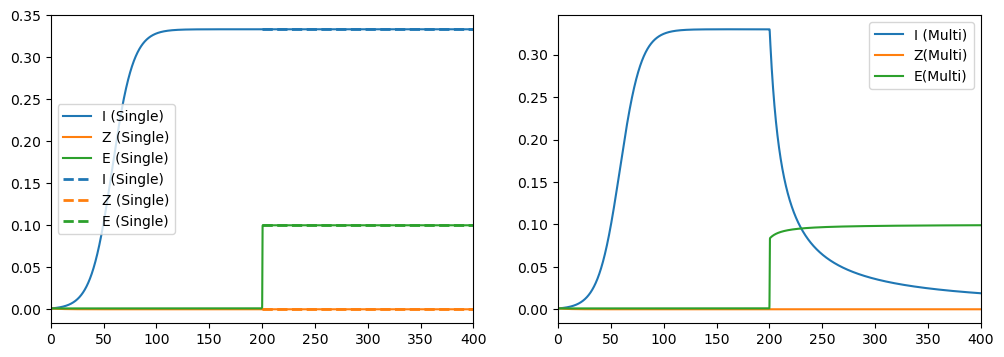

In [6]:
_, a1, a2, a3 = -matA[0,:]
b0, _, b2, b3 = -matA[1,:]
_, c1, c2, c3 = -matA[2,:]
a0 = matA[0,0]
b1 = matA[1,1]
c0 = matA[2,0]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(time,var_wo_cross)
ax.axhline(sat_I_with_given_E(matA,0.0,flag_ionscale_quench=True,flag_zonalflow_quench=True),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C0")
ax.axhline(sat_Z_with_given_E(matA,0.0,flag_ionscale_quench=True,flag_zonalflow_quench=True),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C1")
ax.axhline(matA[2,0]/(-matA[2,3]),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C2")
ax.legend(["I (Single)","Z (Single)","E (Single)","I (Single)","Z (Single)", "E (Single)"])
ax.set_xlim(time[0],time[-1])
ax = fig.add_subplot(1,2,2)
ax.plot(time,var)
# ax.axhline(sat_I_with_given_E(matA,0.0,flag_ionscale_quench=True,flag_zonalflow_quench=True),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C0")
# ax.axhline(sat_Z_with_given_E(matA,0.0,flag_ionscale_quench=True,flag_zonalflow_quench=True),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C1")
# ax.axhline(matA[2,0]/(-matA[2,3]),xmin=0.5,xmax=1,linestyle="dashed",lw=2,c="C2")
ax.legend(["I (Multi)","Z(Multi)","E(Multi)","I (single)","Z (single)", "E (Single)"])
ax.set_xlim(time[0],time[-1])
plt.show()

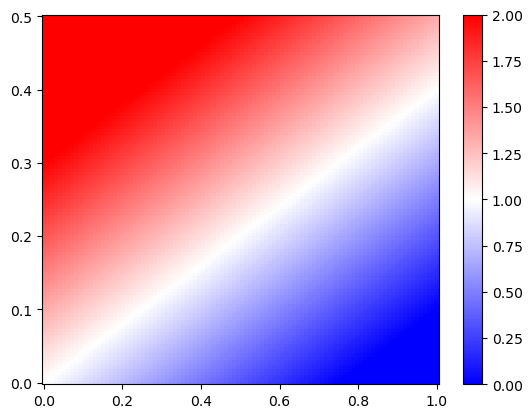

In [58]:
sample_a3E = np.linspace(0,1,100)
sample_b3E = np.linspace(0,0.5,120)
a3E,b3E = np.meshgrid(sample_a3E,sample_b3E)
fig = plt.figure()
ax = fig.add_subplot()
quad = ax.pcolormesh(a3E,b3E,sat_I_ratio_with_given_a3E_b3E(matA,a3E,b3E),cmap="bwr",vmin=0,vmax=2)
fig.colorbar(quad)
plt.show()

In [48]:
print()